# MUDE Q2 PROJECT 
# Optimizing energy production from geothermal reservoirs

#### Submitted by GTRM05 with Group Members:
Tessa Berg    
Ron Gabriel Navarro    
Ashiya Sidheek    
Cristian Tebaldi    
Justin van Beek    

## Introduction
Geothermal energy production is the process of extracting hot water from the ground subsurface to convert the heat into usable energy. The hot water is extracted through a production well and heat is transferred from the water through a heat exchanger. To keep recharging the reservoir, the cooled water is injected back into the subsurface through an injection well, located at a distance from the production well. The cool water heats up while travelling back to the production well. The entire system including the injection and production wells and the reservoir is called a geothermal doublet.
Through time, the temperature extracted from the production well decreases. This temperature is a function of time, and reservoir properties (i.e., thickness, stratification, hydraulic conductivity, etc.). Some of these, including soil properties, are uncontrollable. Design variables include the reservoir dimensions, the distance between the production and injection wells, and the injection and production pressure. In the design of geothermal doublets, these variables can be optimized to produce the most energy out of the lifetime of the doublet. In this assignment the injection and production pressure will be optimized to have the optimal energy production.


## Research objectives
The main research objective of this project is to determine how the reservoir properties affect the energy production of a geothermal doublet. Understanding this allows for optimization of the energy production through alteration of the design variables. The effect of the uncertainty in the reservoir parameters on the energy production is also of interest in this study.


# STAGE 1: Dynamic Modelling of Pressure Distribution and Temperature Production

## Background and Theory of 2D pressure model

Geothermal energy is energy extracted from the ground subsurface. This process is done in a geothermal doublet, which includes a production well, an injection well, and a reservoir. Heat is extracted from hot water from the production well, and the cooled water is injection back into the reservoir through the injection well. The cooled water heats up again while travelling back to the production well. In the Netherlands, there are currently 28 geothermal projects in use. 
The transport of water from the injection well to the production well can be described through a mass-balance equation as shown in Equation 1.


\begin{equation}
\frac{\partial}{\partial t}(\rho \phi) + \nabla\cdot(\rho u) = \rho q\tag{Equation 1}
\end{equation}


Where:     
${\rho}$ = density of water     
${\phi}$ = porosity of the soil     
${u}$ = flow velocity of water through soil     
${q}$ = rate of production     


The first term of Equation 1 represents the accumulation of mass due to compressibility. The second term represents the summation of fluxes coming into and out of the system. Lastly, the term in the right-hand side of the equation if the rate of mass production coming from the production well. In geothermal doublets, it is assumed that the change in water density and soil porosity with respect to time is negligible, such that the first term can be removed.
Darcy’s law describes the velocity of water flow through soil as a function of the hydraulic conductivity of the soil and the pressure gradient. This is shown in Equation 2.

\begin{equation}
u = -\lambda\nabla p\tag{Equation 2}
\end{equation}

Where:    
$λ$ = hydraulic conductivity    
$p$ = pressure    


Substitution of this equation into Equation 1 results to Equation 3. Under the assumption that the density of water is also invariant with respect to space, the density term is cancelled out. The two-dimensional form of the equation is shown in Equation 4. 

\begin{equation}
-\lambda\nabla^2 p = q\tag{Equation 3}
\end{equation}

\begin{equation}
-\lambda(\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}) = q\tag{Equation 4}
\end{equation}

Equation 4 represents the general equation used to describe the flow of the water through the reservoir. It can be characterized as a steady-state Poisson equation in two dimensions. This can be solved by application of the Finite Difference Method.



## PDE pressure solver - FDM approach 

We are using the Finite difference approach to solve the partial differential equation; By discretizing the equation in space, the resulting steady-state equations are solved using matrix algebra. 
Steps involved in 
1.	Reduction of the Partial Differential equation
The mass conservation equation is simplified by assuming that the layers have constant density and porosity, and that the system is in a steady state. This is represented by Equation 3.

2.	Discretizing the reduced Partial differential equation 
The equation is discretized two times by Euler forward difference method, and the transmissibility T of the layers is taken into consideration. The whole 1-D system is divided into a finite N number of cells. The final discretized equation for the ith cell is given in Equation 5.

\begin{equation}
T_i-\frac{1}{2}(p_i - p_{i-1}) + T_i+\frac{1}{2}(p_i - p_{i+1}) = q_i\tag{Equation 5}
\end{equation}


3.	Solving the resulting linear discretized equations using matrix algebra
The resulting equations for N-1 numbers of cells from 0 to N-1 are solved for pressure using matrix algebra with appropriate boundary conditions.

\begin{equation}
Tp = q\tag{Equation 6}
\end{equation}

\begin{equation}
p = T^{-1}q\tag{Equation 7}
\end{equation}

##### The following lines of code solves for the steady-state pressure distribution for the doublet. It includes initialization of parameters, definition of functions, and solving and plotting of pressure values.

### Defining parameters

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

# Defining the given values of our problem:
nx = 60                             # Number of horizontal distance intervals
c = 0.00853                              # Conversion factor
k = np.linspace(1, 1700, 20)              # Absolute permeability in (mD)
n_layers = 20                            # Number of layers


thickness = 200 # thickness of reservoir in m
length = 1200   # lenght of reservoir in m
width = 1000    # width of reservoir in m
time = 100*365  # 100 years of data in days
phi = 0.20      # porosity is 20%
 
P_initial = 200  # initial pressure in reservoir in bars
P_left = 230  # injection pressure in bars
P_right = 170  # production pressure in bars
temp_left = 300  # injection temperature in K
temp_right = 350  # production (initial) temperature in K
well_index = 10  # well index for each layer in m3/day/bar/cpoise

rho_w = 975     # density of water in kg/m3
rho_r = 2500    # density of rock in kg/m3
C_w = 4         # heat capacity of water in kJ/kg/K
C_r = 0.8532    # heat capacity of rock in kJ/kg/K
mu_w = 0.42     # viscosity of water in cpoise
eta = 0.4       # pump efficiency

### Discretization of Reservoir Into Layers and Blocks

In [2]:
# Calculating the distance between each point if we equally space them 
dx = length/(nx-1)
x = np.linspace(0,length,nx)

dz = thickness/n_layers

volume = dx*dz*width
well_index /= volume # convert to right units

### Get data

In [3]:
# load example simulation data
data = pd.read_excel('out_sample_5.xlsx')

# list the collumn names that should be removed
press_gridcells = data.filter(like='reservoir').columns.tolist()
chem_cols = data.filter(like='Kmol').columns.tolist()

# remove collumns from data
data.drop(columns=press_gridcells + chem_cols, inplace=True)


# add time in years
data['Time (yrs)'] = data['time'] / 365.25

data.columns.tolist()

['Unnamed: 0',
 'INJ : temperature (K)',
 'time',
 'INJ : water rate (m3/day)',
 'INJ : steam rate (m3/day)',
 'INJ : energy (kJ/day)',
 'FIPS c 0 (kmol)',
 'INJ : BHP (bar)',
 'PRD : water rate (m3/day)',
 'PRD : steam rate (m3/day)',
 'PRD : temperature (K)',
 'PRD : energy (kJ/day)',
 'PRD : BHP (bar)',
 'Time (yrs)']

### Definition of Functions

#### Function for solving k- matrix and solving p

In [4]:
#Get the matrix that relates u to source f using the getMatrix function
def solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, k, mu_w):
    '''Solves for pressure matrix using 1D FDM given boundary conditions and soil properties
    
    Inputs:
    nx: number of degrees of freedom (number of blocks per layer) ; type = int
    n_layers: number of layers of soil ; type = int
    dx: distance interval ; type = float
    P_left: Pressure at injection well ; type = float
    P_right: Pressure at production well ; type = float
    well_index: well transmisibility coefficient ; type = float
    c: conversion factor ; type = float
    k = soil permeability per layer ; type = float, array
    mu_w: fluid viscosity ; type = float
    
    Returns:
    P: pressure distribution per layer ; type = 2D-array, float
    '''
    Lambda = np.zeros(n_layers)

    for i in range(n_layers):
        Lambda[i] = solve_Lambda(c, k[i], mu_w)
    
    P = np.zeros((n_layers, nx))
    f = np.zeros(nx)

    for i in range(n_layers):
        K = get_matrix(nx, dx, Lambda[i])   
        apply_BCs(K, f, P_left, P_right, well_index, Lambda[i], mu_w) 


        #Calculate u since u = K^-1 * f and K and f are known
        K_inv = np.linalg.inv(K)
        P[i] = np.dot(K_inv, f)
    return P


#### Function for getting k matrix

In [5]:
def get_matrix(nx, dx, Lambda):
    '''Solves the K matrix for finite-difference method
    
    Inputs:
    nx: number of degrees of freedom (number of blocks per layer) ; type = int
    dx: distance interval ; type = float
    Lambda: mobility term ; type = float
    
    Returns:
    K: matrix ; type = float
    '''
    
    # Create an nx x nx matrix with zeros on every entry
    K = np.zeros((nx,nx))
    
    # For each point in from 1 to n-1 add the influence of the point and of it's surroundings
    for i in range(1, nx-1):
        K[i, i] += 2*Lambda/dx**2
        K[i, i-1] -= Lambda/dx**2
        K[i, i+1] -= Lambda/dx**2
    return K

#### Function for specifying boundary conditions 

In [6]:
def apply_BCs(K, f, P_left, P_right, well_index, Lambda, mu_w):
    '''Adjusts the K and f matrices to account for boundary conditions.
    
    Inputs:
    K: matrix ; type = float
    f: vector ; type = float
    P_left: Pressure at injection well ; type = float
    P_right: Pressure at production well ; type = float
    well_index: well transmisibility coefficient ; type = float
    Lambda: mobility term ; type = float
    mu_w: fluid viscosity ; type = float
    '''

    #Apply boundary condition at left side:
    K[0, 0] = (well_index/mu_w) + (Lambda / dx**2) 
    f[0] = (well_index/mu_w) * P_left
    K[0, 1] -= Lambda/dx**2
    
    #Apply boundary condition at right side:
    K[-1, -1] = (well_index/mu_w) + (Lambda / dx**2)
    f[-1] = (well_index/mu_w) * P_right
    K[-1, -2] -= Lambda/dx**2

#### Function for solving matrix of mobility terms

In [7]:
def solve_Lambda(c, k , mu_w):
    
    '''Solves for the mobility term
    Inputs:
    c: conversion factor ; type = float
    k: absolute permeability ; type = float
    mu_w: fluid viscosity ; type = float
    
    Returns:
    Lambda: mobility term ; type = float
    '''
    Lambda = c * (k/mu_w)
    Lambda = Lambda/2
    return Lambda

#### Function for plotting results for pressure

In [8]:
def plot_pressure_results (n_layers, k, P):
    '''Plots permeability values per layer and resulting injection pressure per layer
    
    Inputs:
    n_layers: number of layers ; type = int
    k: permeability values per layer ; type = 1D-array, float
    P: pressure vaues per layer ; type = 1D-array, float
    '''
    
    km = np.zeros((n_layers,nx))
    for i in range(n_layers):
        km [i,:] = k [i]

    plt.figure()
    plt.matshow(km)
    clb = plt.colorbar()
    clb.set_label('Permeability (mD)', labelpad=-40, y=1.05, rotation=0)


    plt.xlabel('Lenght discretization in x direction')
    plt.ylabel('Layers')

    reservoir_p = np.ones(n_layers+1) * 200 # initial pressure   
    reservoir_pd = np.ones(n_layers+1) * 200 # initial pressure 

    for i in range(n_layers):
        string = 'INJ : p ' + str(i) + ' reservoir P (bar)'
        reservoir_p[i] = P[i, 0]

    data = pd.read_excel('out_sample_5.xlsx')
        
    for i in range(n_layers):
        string = 'INJ : p ' + str(i) + ' reservoir P (bar)'
        reservoir_pd[i] = data.at[0, string]

    layer_num = np.linspace(0, n_layers, n_layers+1)

    plt.figure(figsize = (12,7))
    plt.step(reservoir_p, layer_num)
    plt.yticks(layer_num)

    plt.xlabel('Pressure (bar)')
    plt.xlim(200, 230)
    plt.ylabel('Layer')
    # plt.legend()
    plt.grid()


#### Function for delta p

In [9]:
# computing delta p with p well left & p reservoir
def solve_delta_p(P):
    '''Solves delta P
    
    Inputs:
    P: Pressure distribution of each layer; type = float
    
    Return:
    delta_p: difference between injection pressure and pressure at first block ; type = vector (float)
    '''
    delta_p = np.zeros(n_layers)
    for i in range(n_layers):
        delta_p[i] = P_left - P[i,0] 
        
    return delta_p

#### Function for solving temperature production

### Solving and Plotting Pressure

As an initialization, a linspace of permeability values were assigned for the 20 layers and the pressure and temperature solvers were run. Shown below are the visualization of the permeability values per layer and the resulting injection pressure per layer.

<Figure size 432x288 with 0 Axes>

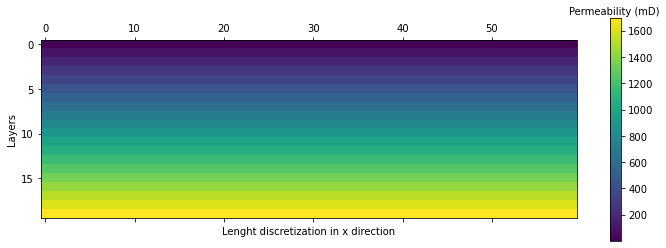

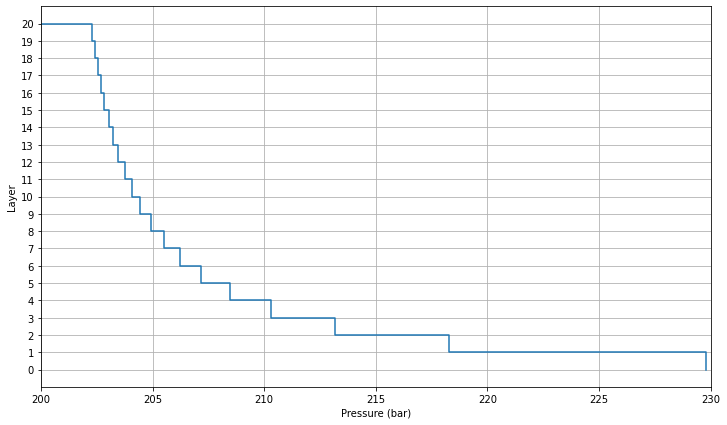

In [10]:
P = solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, k, mu_w)
plot_pressure_results (n_layers, k, P)

## Background and theory temperature solver

Moving to the Thermal Flow it is necessary to introduce some basic thermodynamics concepts. Knowing the morphology of the soil (mostly sandstone in this specific case) it is possible to evaluate the heat capacity of the solid phase itself ${C_r}$  , that must be combined with the heat capacity of the water that flows inside the pores of the soil ${C_w}$. This value can be obtained graphically through the interpretation of the following water enthalpy table:

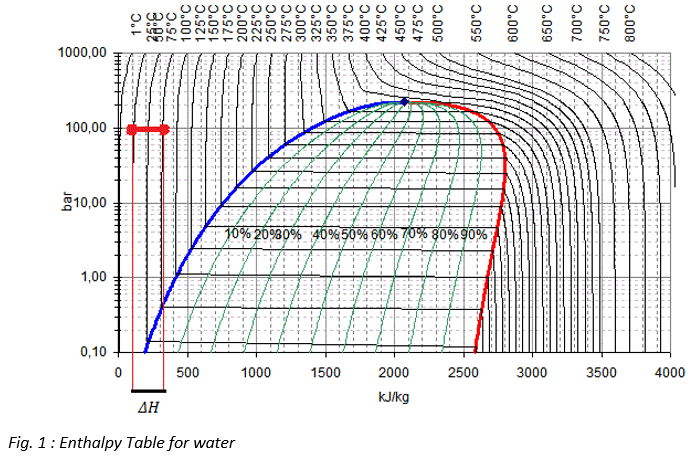

When water is injected into the soil, it acquires energy from the soil solid matrix, that has a higher temperature. This thermodynamic process is assumed as an isobaric transformation while pressure, initial and final temperature are given values:

${p}$ = 100 bar     
$T_1 = 75^o C$     
$T_2 = 25^o C$     

The horizontal, red-underlined drawn line in the diagram shows the variation of enthalpy ΔH (acquisition of energy) of the water during its flow on the ground from the injection point to the well:

\begin{equation}
\Delta H = H_w (T_2) - H_w (T_1)\tag{Equation 8}
\end{equation}

Where:    
$H_w$ = heat extracted from water     
$T$= temperature

Water heat capacity will be defined as:

\begin{equation}
C_w = \frac{\Delta H}{\Delta T}\tag{Equation 9}
\end{equation}

Where:    
$C_w$ = heat capacity of water    

The combination of water and sandstone heat capacity will finally give the volumetric heat capacity that express the amount of heat stored inside the reservoir:

\begin{equation}
C_V = ϕ ρ_w C_w + (1-ϕ)ρ_r C_r\tag{Equation 10}
\end{equation}

Where:    
$C_V$ = volumetric heat capacity of reservoir    
$ϕ$ = porosity of the soil   
$C_r$ - heat capacity of soil    
$ρ_w$= water density     
$ρ_r$= sandstone density       

The well inflow for both the wells is defined as:
\begin{equation}
Q = \Theta^w \Delta p\tag{Equation 11}
\end{equation}

Where:    
$Q$ = well inflow    
$\Theta^w$ = well index       

Hence the equations of the produced energy through the geothermal doublet (Equation 12), the energy spent pumping the water through the wells and inside the ground (Equation 13).

\begin{equation}
E = Q\rho_w C_w (T_1 - T_0) \Delta t\tag{Equation 12}
\end{equation}   

\begin{equation}
E_p = \frac{Q \Delta p}{\eta} \Delta t\tag{Equation 13}
\end{equation}

Where:    
$E$ = well inflow     
$E_p$ = well index   
${Δp}$ = Pressure difference between the boundaries (injection & production) (MPa)    
${η}$ = Efficiency of the pump (normally around 40%)    
   

Note from Equation 13 that the higher is the permeability of the soil, the lower are the pump energy costs.

The lifetime of the doublet can be calculated using Equation 14.

\begin{equation}
t = \frac{L}{v} = \frac{A \rho_r C_r (1-\phi) L}{Q \rho_w C_w}\tag{Equation 14}
\end{equation}

Where:    
$t$ = lifetime of doublet     
$L$ = length of reservoir / distance between wells of doublet    
$v$ = velocity of flow of water

Equations 11 and 14 can be related to an $i$ single layer and since they’re assumed independent one to each other, no thermal exchanges are allowed between them. Depending on the permeability of every layer it is possible to evaluate the velocity of the flow of water inside the layer itself through Equation 14. Depending on the value of every $v_i$, the heat exchange with the soil matrix changes, and if the velocity itself reaches a breakthrough point inside a layer, no temperature variations are assumed for both water and soil and so the thermodynamic exchange cannot happen after a certain velocity of the water. 
Equations 15 expresses the distance covered by the injected water for a specific time inside a layer $l_i$  (with its specific permeability given) and the thermal breakthrough ($\delta i^t$) indicator can be evaluated comparing the obtained value of $l_i$ with the distance $L$ between the injection point and the well. In Equation 15, a dispersion coefficient $D$ between 0 and 1 is applied. $\delta i^t$ is the binary variable that shows whether a layer has achieved thermal breakthrough or not.

\begin{equation}
l_i = D v_i t\tag{Equation 15}
\end{equation}    

\begin{equation}
\delta i^t = 1 \ \ \ if \ l_i>L 
\end{equation}

\begin{equation}
\delta i^t = 0 \ \ \ if \ l_i \le L\tag{Equation 16} 
\end{equation}



Hence, the temperature production at a certain time can be calculated using Equation 17.

\begin{equation}
T = \frac{1}{n_l} \Sigma (T_{inj} \delta i^t + T_{prod}(1- \delta i^t))\tag{Equation 17} 
\end{equation}

Where:    
$T$ = temperature production at time t    
$n_l$ = number of layers    
$T_{inj}$ = temperatuion injection    
$T_{prod}$ = initial temperature production     

The more the time increases the higher is the number of layers going breakthrough until the end of the life of the reservoir, when all the layers will not be involved in heat exchange anymore. This results to a decrease in temperature production over time.

##### The following code solves the temperature production with respect to time. It includes the definition of the function and the plot of the results. For this project, a time frame of 100 years is considered, which is the usual design life of a geothermal doublet.





In [11]:
def solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, D):
    '''Solves the temperature production at different times
    
    Inputs:
    P: Pressure distributuion per layer ; type = 2D-array, float
    dx: distance interval ; type = float
    width: width of entire doublet ; type = float
    dz: height of each layer ; type = float
    n_layers: number of layers of soil ; type = int
    well_index: well transmisibility coefficient ; type = float
    mu_w: fluid viscosity ; type = float
    rho_w: density of water ; type = float
    C_w: volumetric heat capacity of water; type = float
    rho_r: density of rock / soil solid particles ; type = float
    C_r: volumetric heat capacity of rock / soil solid particles; type = float
    phi: porosity of soil ; type = float
    D: dispersion coefficient ; type = float
    
    Returns:
    time_vector: time values at which temperature production is calculated ; type = array, float
    T: Temperature production ; type = array, float
    '''
    delta_p = solve_delta_p(P)

    # Computing rate and velocity
    Tw = (well_index / mu_w) * (dx * width * dz)    #need to multiply with volume of 1 layer 

    # calculate flow rate Q and velocity v of fluid

    Q = np.zeros(n_layers)
    v = np.zeros(n_layers)

    for i in range(n_layers):
        Q[i] = Tw * delta_p[i]   #have a look at this
        v[i] = (Q[i] * rho_w * C_w) / (rho_r * C_r * (1 - phi) * (width * dz))

    # calculate distance travelled l, thermal breakthrough BT and total T
    
    time_vector = np.linspace(0, 100*365, 100)  # 100 years of data in days

    l = np.zeros((len(time_vector), n_layers))       # Travelled distance
    T = np.zeros(len(time_vector))                   # Temperature 
    BT = np.zeros((len(time_vector), n_layers))      # Breakthrough indicator

    for i in range(len(time_vector)):
        for j in range(n_layers):
            l[i,j] = D * v[j] * time_vector[i]    
            if l[i,j] >= length:
                BT[i,j] = 1
            else:
                BT[i,j] = 0

        T[i] =(1 / n_layers) * np.sum(temp_left * BT[i] + temp_right * (1 - BT[i]))
    
    return Q, time_vector, T


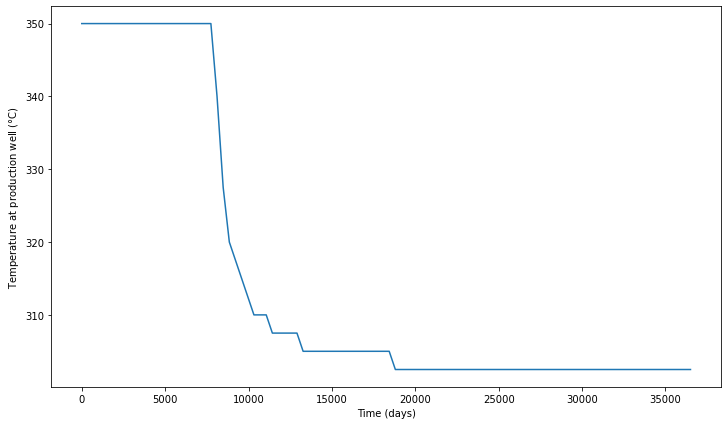

In [12]:
Q, time_vector, T = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 1)

data['Time (yrs)'] = data['time']
plt.figure(figsize = (12,7))
plt.plot(time_vector, T)


plt.ylabel('Temperature at production well ($\degree$C)')
plt.xlabel('Time (days)')
plt.show()

# STAGE 2: Data Assimilation

The absolute permeability k needed to be adjusted to fit the model to the data. To adjust the absolute permeabilitoes, the injection pressures from the excel data were fitted. By trial and error, the permeability values were adjusted such that the pressure calculated would equate to the pressure values obtained from the data. The fitted permeability values and the comparison between the solved pressure values and those obtained from data are shown below.

##### The following code reassigns the values of permeability to better fit the data, and resolves for pressure distribution and temperature production.



### Changing the values of k and resolving P and T

In [13]:
# Changing the k values to correctly fit the given data

k=[275,90,1650,250,155,65,1360,690,130,95,340,1175,
   230,260,250,255,200,110,160,650] #trial and error absolute permeability in (mD)

P = solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, k, mu_w)

Text(0, 0.5, 'Layers')

<Figure size 432x288 with 0 Axes>

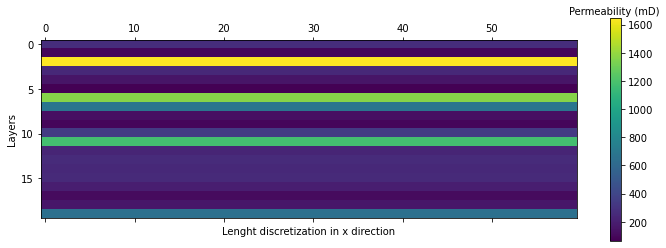

In [14]:
km = np.zeros((n_layers,nx))
for i in range(n_layers):
    km [i,:] = k [i]
    
plt.figure()
plt.matshow(km)
clb = plt.colorbar()
clb.set_label('Permeability (mD)', labelpad=-40, y=1.05, rotation=0)


plt.xlabel('Lenght discretization in x direction')
plt.ylabel('Layers')


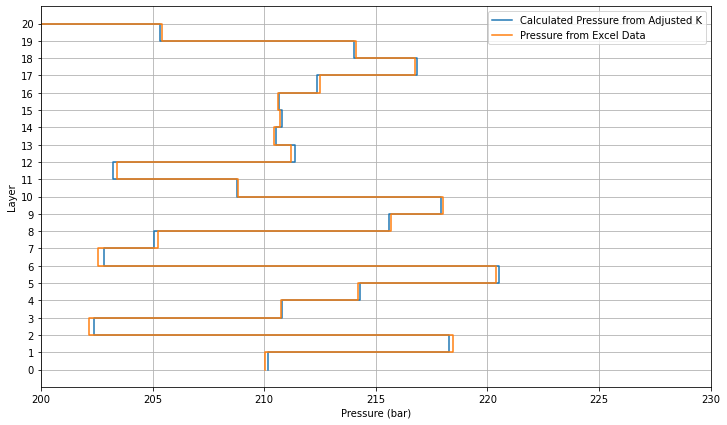

In [15]:
reservoir_p = np.ones(n_layers+1) * 200 # initial pressure   
reservoir_pd = np.ones(n_layers+1) * 200 # initial pressure 

for i in range(n_layers):
    string = 'INJ : p ' + str(i) + ' reservoir P (bar)'
    reservoir_p[i] = P[i, 0]
    
data = pd.read_excel('out_sample_5.xlsx')

for i in range(n_layers):
    string = 'INJ : p ' + str(i) + ' reservoir P (bar)'
    reservoir_pd[i] = data.at[0, string]

layer_num = np.linspace(0, n_layers, n_layers+1)
    
plt.figure(figsize = (12,7))
plt.step(reservoir_p, layer_num, label = 'Calculated Pressure from Adjusted K')
plt.step(reservoir_pd, layer_num, label = 'Pressure from Excel Data')
plt.yticks(layer_num)

plt.xlabel('Pressure (bar)')
plt.xlim(200, 230)
plt.ylabel('Layer')
plt.legend()
plt.grid()   
    
    


In [16]:
Q, time_vector, T = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 0.66)
Q, time_vector, T_D1 = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 1)


### Adjusting D

Fitting of the temperature production was also performed. Initially, the calculated temperature production did not fit the data when a dispersion coefficient $D$ = 1 was used. It needed to be adjusted to $D$ = 0.66. After adjusting the dispersion coefficient the temperature curve estimated by the dynamic model matched the temperature curve from the data. 

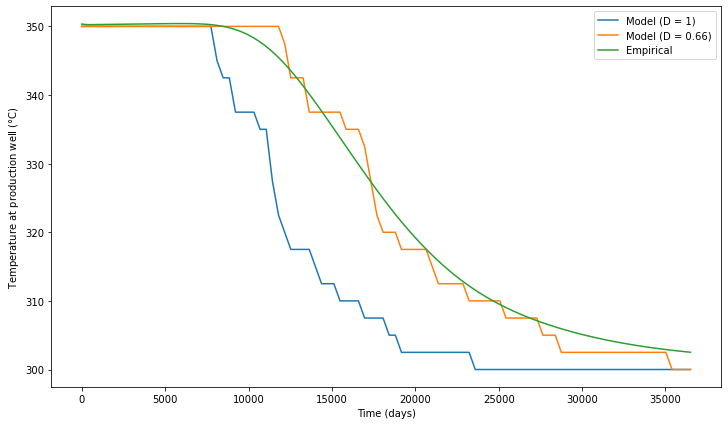

In [17]:
data['Time (yrs)'] = data['time']
plt.figure(figsize = (12,7))
plt.plot(time_vector, T_D1, label='Model (D = 1)')
plt.plot(time_vector, T, label = 'Model (D = 0.66)')
plt.plot(data['Time (yrs)'],data['PRD : temperature (K)'], label = 'Empirical')

plt.ylabel('Temperature at production well ($\degree$C)')
plt.xlabel('Time (days)')
plt.legend()
plt.show()

# STAGE 3: Optimization and Uncertainty Analysis

### Optimizing the boundary pressure

The injection pressure on the left side of the reservoir and the production pressure on the right can be adjusted to achieve maximum energy output, minimal pump power, and longer doublet life. The parameters that can be optimized in this design are thus either the injection pressure or the production pressure. By changing one of these, the difference in pressure over the layer will change and therefore the energy production from the doublet and pumping energy change.

Recall that the energy that is produced by the doublet is calculated using Equation 12 and the pumping energy is calculated using Equation 13. The doublet and pumping powers can consequently be computed by dividing the energies by the unit time dimension used. In this case, the unit time dimension used for the calculations is 1 day.

The economic value in terms of energy, represented by the variable $F$, of the reservoir can be estimated from the doublet energy (benefit) and pumping energy (costs) using Equation 18. The plots of $F$ over time for different values of $ΔP$ are shown below. It can be seen that at the timeframe assumed of 100 years, the doublet is still economical for most values of $ΔP$, specifically below 40kPa, as the value of $F$ is still positive. To determine the optimal $ΔP$ value, the integral of F is taken over the entire timeframe considered as shown in Equation 19. One value of designed pressure difference $ΔP$, this gives one value for $f_{opt}$. By running the forward model multiple times with different $ΔP$ and then calculating the integral, we get different $f_{opt}$ values at different $ΔP$'s. By plotting these against each other, a curve is obtained that shows at which $ΔP$ the $f_{opt}$ value is largest. 

\begin{equation}
F = 40 * E_{doublet} - 100 * E_{pump} \tag{Equation 18} 
\end{equation}


\begin{equation}
f_{opt} = \int (40 * E_{doublet} - 100 * E_{pump}) \, dt \tag{Equation 19} 
\end{equation}

##### The following code solves for the doublet and pumping energy /  power, production temperature, rate, and $F$ for $ΔP$ = 20, 40, 60, and 80 bar. Optimization based on the above theory and equation is also performed and relevant graphs are plotted.


In [18]:
def optimization(Q_layer, rho_w, C_w, T_left, P_left, P_right, eta, T, time):
    '''Function to compute the power and energy from doublet and pump,
    and calculate the optimization value and integral over lifetime of doublet.
    input:
    Q_layer: Q for each layer from forwardmodel (m3/d)
    rho_w: density of water (kg/m3)
    c_w: heat capacity of water (J/(kgK))
    T_left: injection temperature (K)
    P_left: injection pressure (MW)
    P_right: production pressure (MW)
    eta: pump efficiency (-)
    T: Production temperature over time (K)
    time: time vector (life time of doublet) (days)
    
    Output: different graphs'''
    
    
    # compute delta_t
    delta_t  = 1
    
    # compute delta p
    delta_p = P_left - P_right
    
    
    # compute Q (total volume flow rate)
    Q = np.sum(Q_layer) / (24 * 3600)   #convert to m3/s
    Q_array = np.ones(len(time))* Q * 24 * 3600

    # compute E doublet and pump
    E_doublet = Q * rho_w * (C_w/1000) * (T - T_left) * delta_t
    P_doublet = Q * rho_w * (C_w/1000) * (T - T_left) 
    E_pump = (Q * delta_p) / eta * delta_t / 10
    P_pump = np.ones(len(time))*((Q * delta_p) / eta)/10 

    
    # optimzation function
    F_opt = 40 * E_doublet - 100 * E_pump
    
    
    #compute integral of F optimization function over life time doublet,
    # F_opt is an array dependent on time, gives 1 value for 1 pressure difference.
    integral_F_opt = np.sum(F_opt*(time_vector[1]-time_vector[0]))
    
    return integral_F_opt, F_opt, Q_array, P_doublet, P_pump


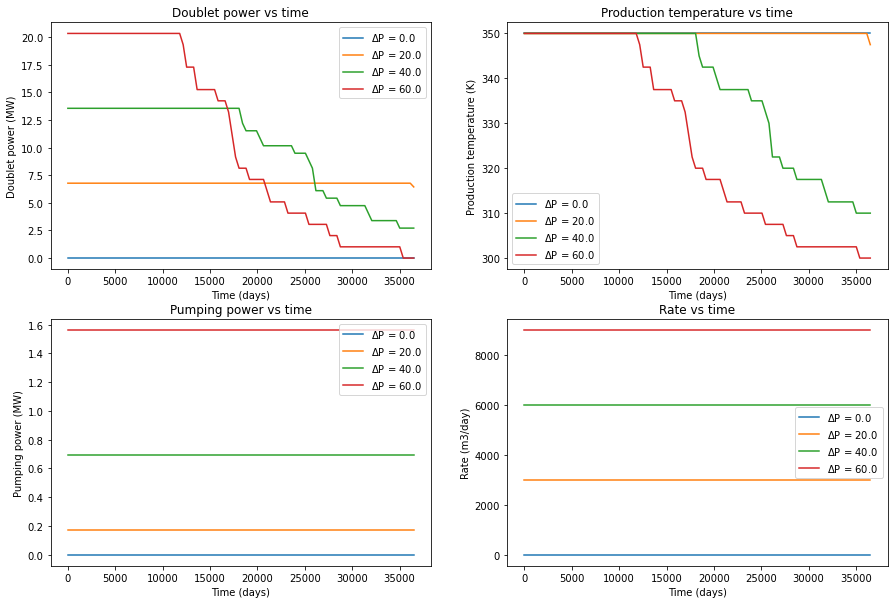

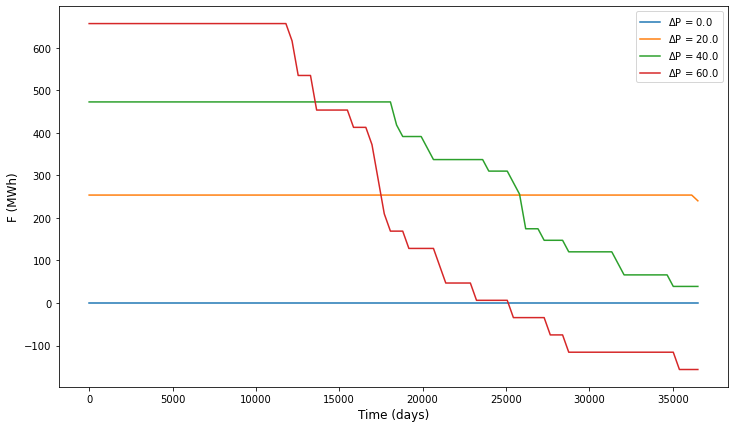

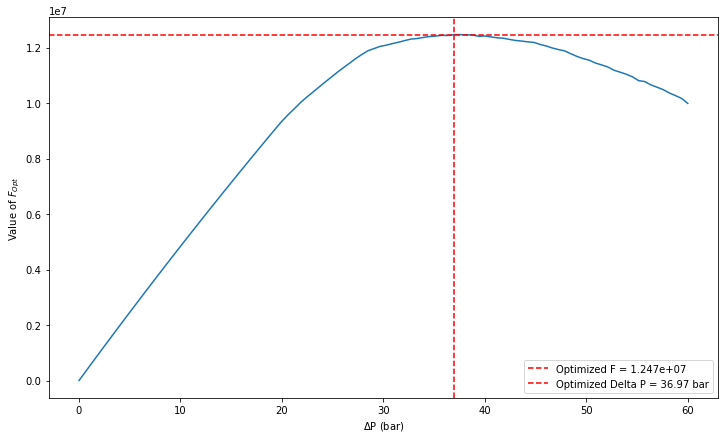

In [19]:
P_left_vector = np.linspace(170, 230, 4)

#plot figures
fig, axs = plt.subplots(2,2, figsize = (15,10))
for P_left in (P_left_vector):
    P = solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, k, mu_w)
    Q, time_vector, T = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 0.66)
    integral_F_opt, F_opt, Q_array, P_doublet, P_pump = optimization(Q, rho_w, C_w, temp_left, P_left, P_right, eta, T, time_vector)
    axs[0,0].plot(time_vector, P_doublet, label = f'$\Delta$P = {P_left-P_right}')
    axs[0,0].set_xlabel('Time (days)')
    axs[0,0].set_ylabel('Doublet power (MW)')
    axs[0,0].set_title('Doublet power vs time')
    axs[0,0].legend()
    axs[0,1].plot(time_vector, T, label = f'$\Delta$P = {P_left-P_right}')
    axs[0,1].set_xlabel('Time (days)')
    axs[0,1].set_ylabel('Production temperature (K)')
    axs[0,1].set_title('Production temperature vs time')
    axs[0,1].legend()
    axs[1,0].plot(time_vector, P_pump, label = f'$\Delta$P = {P_left-P_right}')
    axs[1,0].set_xlabel('Time (days)')
    axs[1,0].set_ylabel('Pumping power (MW)')
    axs[1,0].set_title('Pumping power vs time')
    axs[1,0].legend()
    axs[1,1].plot(time_vector, Q_array, label = f'$\Delta$P = {P_left-P_right}')
    axs[1,1].set_xlabel('Time (days)')
    axs[1,1].set_ylabel('Rate (m3/day)')
    axs[1,1].set_title('Rate vs time')
    axs[1,1].legend()

plt.figure(figsize = (12, 7))
for P_left in (P_left_vector):
    P = solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, k, mu_w)
    Q, time_vector, T = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 0.66)
    integral_F_opt, F_opt, Q_array, P_doublet, P_pump = optimization(Q, rho_w, C_w, temp_left, P_left, P_right, eta, T, time_vector)
    plt.plot(time_vector, F_opt, label = f'$\Delta$P = {P_left-P_right}')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('F (MWh)', fontsize=12)
plt.legend()
plt.show()    

P_left_vector = np.linspace(170, 230, 100)
delta_P_vector = P_left_vector - P_right

#compute value of integral for different pressure differences (due to different boundary conditions)
integral_F_opt_vector = np.zeros(len(P_left_vector))

plt.figure(figsize = (12, 7))
for i, P_left in zip(range(len(P_left_vector)), P_left_vector):
    P = solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, k, mu_w)
    Q, time_vector, T = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 0.66)
    integral_F_opt_vector[i], F_opt, Q_array, P_doublet, P_pump = optimization(Q, rho_w, C_w, temp_left, P_left, P_right, eta, T, time_vector)

max_integral = np.max(integral_F_opt_vector)
max_delta_P = delta_P_vector[integral_F_opt_vector.argmax()]
    
plt.plot(delta_P_vector ,integral_F_opt_vector)
plt.axhline(max_integral, color = 'red', ls = '--', label = f'Optimized F = {max_integral:.4}')
plt.axvline(max_delta_P, color = 'red', ls = '--', label = f'Optimized Delta P = {max_delta_P:.5} bar')
plt.xlabel(f'$\Delta$P (bar)')
plt.ylabel('Value of $F_{Opt}$')
plt.legend()
plt.show()

For a timeframe of 100 years, the optimal $ΔP$ value is around 37 bar. As mentioned, doublets with $ΔP$ < 40 have $F$ > 0 at this time, and it is expected that when the timeframe considered is longer, the optimal $ΔP$ value might be lower. However, it does not seem reasonable to consider a doublet design life of greater than 100 years.

### Uncertainty of Soil Permeability

The value of the permeability $k$ is not exactly known and some uncertainty should be included in the design of the doublet. An uncertainty (standard deviation) of 10% is assumed in the values of $k$.

To account for the fact that some k values can increase and some will decrease under uncertainty, a Monte Carlo simulation is done. The monte carlo simulation gives a more precise overview of the range and distribution of the optimal delta p.

For each run of the optimization model a new set of k values (1 for each layer) is collected from a normal distribution. This follows an assumption that the value of hydraulic conductivity has an equal probability of being higher or lower than the expected value. Each layer has it’s own normal distribution with mean and standard deviation. The means are taken as the values obtained from data assimilation and the standard deviations are taken as 10% of the means. The optimization model was run for 1000 different samples of k.


##### The following code performs Monte Carlo simulation for the calculation of optimal ${\Delta}P$ values from different samples of $k$.

In [20]:
# determine new k array
def randomk(k):
    '''Samples a value of k from a normal distribution'''
    mu = np.array(k)
    sig = 0.1*mu

    kdrawn = np.zeros(len(mu))
    for i in range(len(mu)):
        kdrawn[i] = mu[i] + sig[i] * np.random.normal()

        
    return kdrawn

In [21]:
kdrawn = randomk(k)

In [22]:
# run 1000 monte carlo simulations with 1000 k vectors drawn from normal distributions.
delta_p_pdf = np.zeros(1000)

for j in range(1000):
    kdrawn = randomk(k)

    P_left_vector = np.linspace(170, 230, 1000)
    delta_P_vector = P_left_vector - P_right

    #compute value of integral for different pressure differences (due to different boundary conditions)
    integral_F_opt_vector = np.zeros(len(P_left_vector))

    for i, P_left in zip(range(len(P_left_vector)), P_left_vector):
        P = solve_pressure (nx, n_layers, dx, P_left, P_right, well_index, c, kdrawn, mu_w)
        Q, time_vector, T = solve_temp_production (P, dx, width, dz, n_layers, well_index, mu_w, rho_w, C_w, rho_r, C_r, phi, 0.66)
        integral_F_opt_vector[i], F_opt, Q_array, P_doublet, P_pump = optimization(Q, rho_w, C_w, temp_left, P_left, P_right, eta, T, time_vector)

    max_integral = np.max(integral_F_opt_vector)
    max_delta_P = delta_P_vector[integral_F_opt_vector.argmax()]
    delta_p_pdf[j] = max_delta_P

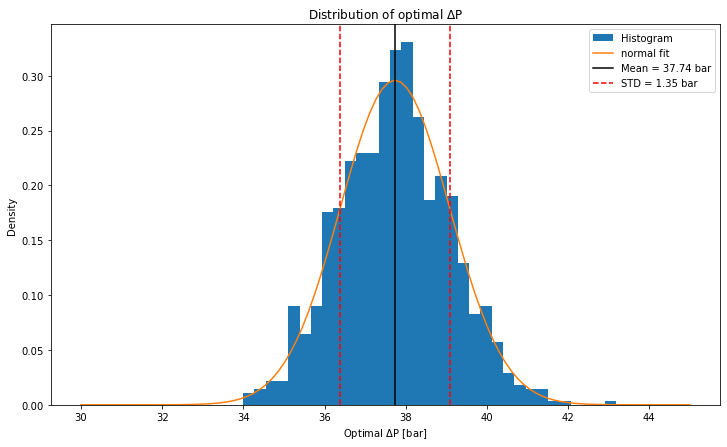

In [26]:
#plot histogram of optimal delta p's and fitted normal distribution.

plt.figure(figsize = (12,7))
plt.hist(delta_p_pdf, bins=33, density = True, label='Histogram')
plt.xlabel(f'Optimal $\Delta$P [bar]')
plt.ylabel(f'Density') 
plt.title(f'Distribution of optimal $\Delta$P')
          
    
x_axis = np.linspace(30, 45, 100)    
mean = np.mean(delta_p_pdf)
std = np.std(delta_p_pdf)
plt.plot(x_axis, norm.pdf(x_axis, mean, std), label='normal fit')
plt.axvline(mean, color = 'black', label = f'Mean = {mean:.2f} bar')
plt.axvline(mean+std, color = 'red', ls = '--', label = f'STD = {std:.2f} bar')
plt.axvline(mean-std, color = 'red', ls = '--')

plt.legend()


### Conclusion 

The histogram of the resulting optimal $\Delta$P values resembles a normal distribution. The mean of the optimal $\Delta$P is 37.74 bar and the standard deviation is 1.35 bar, which is around 3.6% of the mean. A 10% uncertainty in the k-values propragates through the optimization model, resulting in only 3.6% uncertainty in the optimal $\Delta$P, showing that there is less relative uncertainty needed to be considered in the design of the pressure boundaries. Changing the number of samples to 100 or 10000 doesn't change the mean and standard deviation, thus the 1000 samples used is enough for the Monte Carlo simulation.

In conclusion, a pressure difference of 38 bar is recommended for the design of the geothermal doublet considering a lifetime of 100 years. The injection pressure is recommended at 208 bar while the production pressure is kept at 170 bar.

### References

Cariaga, C. (2022). Geothermal industry in the Netherlands has promising potential for strong growth. Retrieved from https://www.thinkgeoenergy.com/geothermal-industry-in-the-netherlands-has-promising-potential-for-strong-growth/    
    
MUDE Slides by Denis Voskov, Alexandros Daniilidis, and Hadi Hajibeygi
